<a href="https://colab.research.google.com/github/y2236li/Algorithm-Practice/blob/master/Train_2D_Climber_on_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
%load_ext autoreload

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()
accuracy_lookuptb = {}

In [0]:
## Tuner:
## Input: ML Model, Param_range
## Output: Best configuration

## Function

In [0]:
def calAccuracy(args, XY):
  """
  Calculate the accuracy
  return: accuracy
  """
  global accuracy_lookuptb
  global mdl


  assert str(args) not in accuracy_lookuptb

  X_train, X_test, Y_train, Y_test = XY
  m = mdl(**args)
  m.fit(X_train, Y_train)
  Y_pred = m.predict(X_test)
  y = r2_score(Y_pred, Y_test)
  accuracy_lookuptb[str(args)] = y

  return y


def calReward(args, mdl, XY = None):
  global accuracy_lookuptb

  args_str = str(args)
  if args_str not in accuracy_lookuptb:
    assert XY
    return calAccuracy(args, XY)
  return accuracy_lookuptb[args_str]

def detect(param_name, detect_range, param_range,  args, XY = None):
  """
  return the accuracy of detecting area around the x
  
  """
  global accuracy_lookuptb
  global mdl

  assert param_name in args
  
  param_detect_range = np.array(detect_range) + args[param_name]
  param_detect_range = [max(min(x, max(param_range)), min(param_range)) for x in param_detect_range]

  args_list = []
  for pos in param_detect_range:
    args_list.append(args.copy())
    args_list[-1][param_name] = pos


  res = []
  for arg in args_list:
    if str(arg) in accuracy_lookuptb:
      res.append(accuracy_lookuptb[str(arg)])
    else:
      assert XY
      res.append(calAccuracy(arg, XY))
  
  return res



def step(a, action, param_range, XY = None):
  global mdl
  global last_mom
  global mom_ind
  global accuracy_lookuptb

  cur_val = a.cur_val
  args = a.args
  param_name = a.param_name
  detect_range = a.detect_range
  cur_detection = a.cur_dct
  last_mom = a.cur_gre


  cur_x = args[param_name]

  next_x = max(min(max(param_range), cur_x + action), min(param_range))

  args[param_name] = next_x

  if str(args) not in accuracy_lookuptb:
    assert XY
    next_detection = detect(param_name, detect_range, param_range, args, XY)
  else:
    next_detection = detect(param_name, detect_range, param_range, args, XY)
  
  next_gre = np.array(next_detection) - np.array(cur_detection) + np.array(last_mom) * mom_ind

  next_state = np.array(list(next_detection) + list(next_gre) + list(args.values()))

  reward = calReward(args, mdl, XY)

  a.updateArg(next_x, next_gre, next_detection)

  return (next_state, next_x, reward, a)




def writeMem(cur_state, next_state, action, reward, a):
  global mem_ctr
  index = mem_ctr % mem_size

  if isinstance(a.state_mem, dict) or (a.state_mem.shape[0] > index):
    a.state_mem[index] = cur_state
    a.next_state_mem[index] = next_state
    tmp_onehot = np.zeros(len(a.step_options), dtype=np.int64)
    tmp_onehot[list(a.step_options).index(action)] = 1
    a.onehot_action_mem[index] = tmp_onehot
    a.reward_nor_mem[index] = reward
    return a
    
  a.state_mem = np.append(a.state_mem, [cur_state], axis=0)
  a.next_state_mem = np.append(a.next_state_mem, [next_state], axis=0)
  tmp_onehot = np.zeros(len(a.step_options), dtype=np.int64)
  tmp_onehot[list(a.step_options).index(action)] = 1
  a.onehot_action_mem = np.append(a.onehot_action_mem, [tmp_onehot], axis=0)
  a.reward_nor_mem = np.append(a.reward_nor_mem, reward)
  return a


def norState(cur_state_dtc, cur_state_gre, cur_state_x, scaler_state):
  scaler_state_dtc, scaler_state_gre, scaler_state_x = scaler_state

  cur_state = np.array(list(cur_state_dtc) + list(cur_state_gre) + cur_state_x)

  cur_nor_state_dtc = scaler_state_dtc.transform([cur_state_dtc])[0]
  cur_nor_state_gre = scaler_state_gre.transform([cur_state_gre])[0]
  cur_nor_state_x = scaler_state_x.transform([cur_state_x])[0]

  cur_nor_state = np.array(list(cur_nor_state_dtc) + list(cur_nor_state_gre) + list(cur_nor_state_x))

  return cur_state, cur_nor_state



def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

# def calRewardTest(x):
#   return accuracy_lookuptb_test[x]


# def detectTest(detect_range, x, accuracy_lookuptb_test = None):
#   """
#   return the accuracy of detecting area around the x
#   """
#   x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
#   if not accuracy_lookuptb_test:
#     return [calAccuracyTest(pos) if pos in x_range else 0 for pos in x_detect_range]
#   return [accuracy_lookuptb_test[pos] if pos in x_range else 0 for pos in x_detect_range]



# def stepTest(cur_state, action, cur_x, accuracy_lookuptb_test):
#   next_x = int(max(min(max(x_range), cur_x + action), 1))
#   next_state = detectTest(detect_range, next_x, accuracy_lookuptb_test)
#   reward = calRewardTest(next_x)
#   return (next_state, reward)

## Agent Class

In [0]:
class agent():
  def __init__(self, param_name, detect_range, step_options, args):
    ## update at initialization
    self.param_name = param_name
    self.detect_range = detect_range
    self.step_options = step_options

    ## update every step
    self.cur_val = args[param_name]
    self.args = args
    self.cur_gre = np.zeros(len(detect_range))
    self.cur_dct = np.zeros(len(detect_range))
    self.cur_state = np.zeros(len(detect_range)*2+1)

    #memory
    self.state_mem = {}
    self.onehot_action_mem = {}
    self.reward_nor_mem = {}
    self.next_state_mem = {}
    self.terminal_mem = {}
    self.visited_val = {}

    ##scalers
    self.state_scaler = MinMaxScaler()
    self.reward_scaler = MinMaxScaler()


  def updateArg(self, cur_val, cur_gre, cur_dct):
    self.cur_val = cur_val
    self.cur_gre = cur_gre
    self.cur_dct = cur_dct
    self.args[self.param_name] = cur_val
    self.cur_state = np.array(list(cur_dct) + list(cur_gre) + list(self.args.values()))

  def updateMdl(self, q_model):
    self.q_model = q_model

  def resetPos(self, args, XY):
    global param_range

    self.cur_val = args[param_name]
    self.args = args
    self.cur_gre = np.zeros(len(detect_range))
    self.cur_dct = detect(self.param_name, self.detect_range, param_range[self.param_name], args, XY)
    self.updateArg(a.cur_val, a.cur_gre, a.cur_dct)



  def __enter__(self):
    return self
  
  def __exit__(self, type, value, traceback):
    pass

## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

XY = (X_train, X_test, Y_train, Y_test)

mdl = SVR
tuning_args = ["C", "gamma"]
init_args = {'C': 150, 'gamma': 100}


idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

lr = 0.01 # also alpha


gamma = 0.8
mom_ind = 0.8
mem_ctr = 0

## Game Initialization

In [0]:
agents = {}
param_range = {}
param_name = "C"
unit = 100
param_range["C"] = range(100, 10000, unit)
detect_range = np.array([-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11])*unit # also input dim
step_options = np.array([-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11])*unit # also action space

agents[param_name] =  agent(param_name,detect_range, step_options, init_args.copy())


param_name = "gamma"
unit = 1
param_range["gamma"] = np.arange(1, 1/(np.var(X_train)*X_train.shape[1]), unit)
detect_range = np.array([-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11])*unit # also input dim
step_options = np.array([-11, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 11])*unit # also action space
agents[param_name] =  agent(param_name,detect_range, step_options, init_args.copy())


mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size

for k in tuning_args:
  with agents[k] as a:
    a.cur_val = init_args.copy()[k]
    a.cur_dct = detect(a.param_name, a.detect_range, param_range[k], init_args, XY)
    a.cur_gre = np.zeros(len(a.detect_range))
    a.updateArg(a.cur_val, a.cur_gre, a.cur_dct)

In [194]:
agents["C"].state_mem

{}

## Make NN Model

In [0]:
def makeModel(a):
  fc1_dims = 200
  fc2_dims = 200
  model = Sequential([
      Dense(fc1_dims, input_shape=(np.array(a.cur_state).shape[0],)),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(len(a.step_options))
  ])


  # model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='mse')
  model.compile(optimizer=Adam(lr=0.001), loss='mse')

  return model

for arg in tuning_args:
  q_model = makeModel(agents[arg])
  agents[arg].updateMdl(q_model)

## Random Walk

Starting at  {'C': 100, 'gamma': 100}


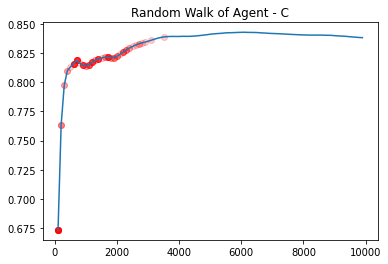

Starting at  {'C': 3400, 'gamma': 100}


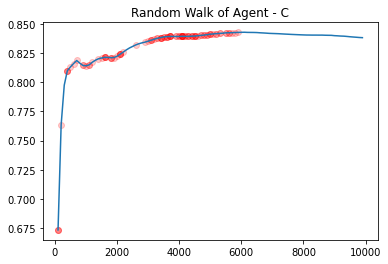

Starting at  {'C': 6700, 'gamma': 100}


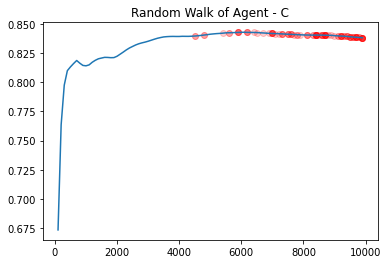

Starting at  {'C': 150, 'gamma': 1.0}


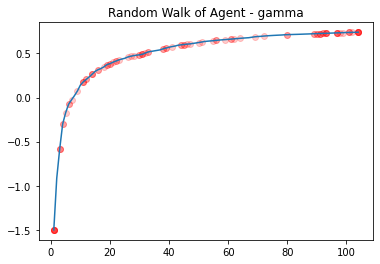

Starting at  {'C': 150, 'gamma': 35.0}


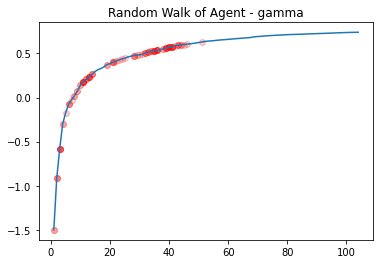

Starting at  {'C': 150, 'gamma': 69.0}


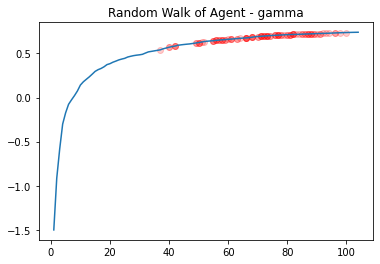

In [196]:
n_rw = 3

random_walk_period = one_game_steps//n_rw

assert random_walk_period * n_rw <= mem_size



for param_name in tuning_args:
  a = agents[param_name]

  for n_rw_ctr in range(n_rw):
    tmp_init_args = init_args.copy()
    tmp_init_args[param_name] = param_range[param_name][len(param_range[param_name])//3 * n_rw_ctr]
    print("Starting at ", tmp_init_args)
    a.resetPos(tmp_init_args.copy(), XY)

    for _ in tqdm(range(random_walk_period)):
      action = a.step_options[np.random.choice(len(a.step_options))]
      cur_state = a.cur_state.copy()
      next_state, next_val, reward, a = step(a, action, param_range[a.param_name], XY)
      a = writeMem(cur_state.copy(), next_state.copy(), action, reward, a)
      mem_ctr += 1
      # print(a.cur_state)

      plt.scatter(next_val, reward, c='r', alpha=max(0.2, 1/(step_ctr+1)))

    actual_acc_list = []
    for c in tqdm(param_range[param_name]):
      tmp_args = a.args.copy()
      tmp_args[param_name] = c
      actual_acc_list.append(calReward(tmp_args, mdl, XY))
    plt.plot(param_range[param_name], actual_acc_list)
    plt.title("Random Walk of Agent - " + param_name)
    plt.show()

## Normalize Memory Based on Random Walk

In [0]:
for param_name in tuning_args:
  a = agents[param_name]
  min_args = [min(param_range[pn]) for pn in tuning_args]
  max_args = [max(param_range[pn]) for pn in tuning_args]
  min_state = np.array(list(a.cur_dct) + list(a.cur_gre) + list(min_args))
  max_state = np.array(list(a.cur_dct) + list(a.cur_gre) + list(max_args))
  state_mem_array = np.array(list(a.state_mem.values()))
  next_state_mem_array = np.array(list(a.next_state_mem.values()))
  #create scaler for states
  state_scaler = MinMaxScaler()
  state_scaler.fit(np.concatenate((state_mem_array, [min_state], [max_state]), axis=0))
  a.state_mem = state_scaler.transform(state_mem_array)
  a.next_state_mem = state_scaler.transform(next_state_mem_array)
  a.state_scaler = state_scaler
  #create scaler for rewards
  reward_scaler = MinMaxScaler()
  reward_scaler.fit([[x] for x in a.reward_nor_mem.values() if x > 0.6])
  a.reward_nor_mem = reward_scaler.transform([[x] for x in a.reward_nor_mem.values()]).reshape((1, -1))[0]
  a.reward_scaler = reward_scaler

  # change dict to np.array
  a.onehot_action_mem = np.array(list(a.onehot_action_mem.values()))


In [198]:
q_matrix.argmax(axis=1)

array([11, 11, 11, 11, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11,  0,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  8, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

## Start Training

Starting at  {'C': 1500, 'gamma': 104.0}



End at  [ 8.40986370e-01  8.41886245e-01  8.42259063e-01  8.42465043e-01
  8.42423216e-01  8.42403595e-01  8.42459775e-01  8.42316178e-01
  8.42147356e-01  8.42001012e-01  8.41781748e-01  8.41505535e-01
  8.41007367e-01 -1.73102413e-05  2.29779969e-04  2.12972211e-04
  2.64847554e-04  2.03913937e-04  1.89368057e-04  2.49687778e-04
  1.68767150e-04  1.09188408e-04  3.21188548e-05  1.02197137e-05
  6.96754558e-05 -2.42272313e-05  5.90000000e+03  1.04000000e+02]


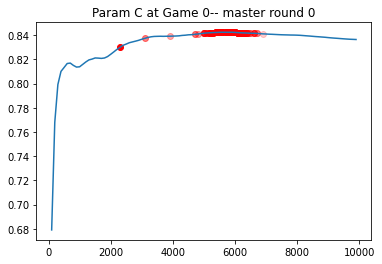

Starting at  {'C': 6100, 'gamma': 90.0}



End at  [ 8.43097386e-01  8.43211991e-01  8.43060017e-01  8.42894238e-01
  8.42574037e-01  8.42324494e-01  8.42147356e-01  8.42147356e-01
  8.42147356e-01  8.42147356e-01  8.42147356e-01  8.42147356e-01
  8.42147356e-01  2.31905940e-32  2.19093050e-32  1.67334779e-32
  1.59113659e-32  3.86572994e-33  2.21773625e-33 -5.45717999e-33
 -5.45445277e-33 -9.65858178e-33 -1.00379191e-32 -1.19916674e-32
 -1.06215230e-32 -7.89147881e-33  6.10000000e+03  1.04000000e+02]


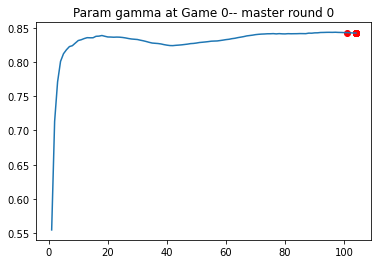

Cur Master =  {'C': 5600, 'gamma': 101.0}  With reward =  0.8426920534704669
Starting at  {'C': 3800, 'gamma': 101.0}



End at  [ 8.41674661e-01  8.42486122e-01  8.42775368e-01  8.43059773e-01
  8.43002646e-01  8.42894238e-01  8.42899761e-01  8.42829190e-01
  8.42686785e-01  8.42589606e-01  8.42217665e-01  8.41853151e-01
  8.41366398e-01 -1.41104924e-05  1.16320189e-06 -3.63532186e-06
  1.21319926e-05  8.64498096e-06  5.54691787e-06  9.83445950e-06
  1.01823296e-05  1.06790837e-05  1.26856214e-05  9.26312975e-06
  9.55531739e-06  5.13310113e-06  6.20000000e+03  1.01000000e+02]


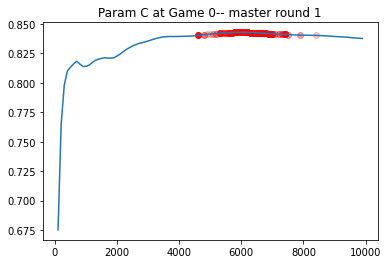

Starting at  {'C': 5600, 'gamma': 69.0}



End at  [8.41724902e-01 8.42402644e-01 8.42515048e-01 8.42692053e-01
 8.42495805e-01 8.42432154e-01 8.42465043e-01 8.42465043e-01
 8.42465043e-01 8.42465043e-01 8.42465043e-01 8.42465043e-01
 8.42465043e-01 1.45979965e-31 1.35020917e-31 1.11091658e-31
 1.00839271e-31 8.56414080e-32 7.59977695e-32 7.05896653e-32
 6.10297045e-32 5.39397247e-32 4.45736153e-32 3.44223368e-32
 2.43445831e-32 2.12608456e-32 5.60000000e+03 1.04000000e+02]


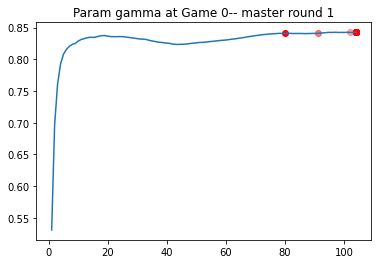

Cur Master =  {'C': 5900, 'gamma': 101.0}  With reward =  0.8430597732929286
CPU times: user 2min 1s, sys: 37.7 s, total: 2min 39s
Wall time: 1min 53s


In [230]:
%%time
training_his_max_reward = {}

n_mstr_round = 2
n_games = 1
one_game_steps = 300
rule_idle = False

master_args = init_args.copy()

for n_mstr_ctr in range(n_mstr_round):

  max_args = {}

  # for param_name in tuning_args:
  for param_name in tuning_args:
    a = agents[param_name]

    a.resetPos(master_args.copy(), XY)

    reward_nor_buffer = []

    reward_nor_his = []

    unit_step = min([abs(x) for x in a.step_options])

    tmp_max_args = master_args.copy()
    tmp_max_reward = calReward(master_args.copy(), mdl)

    for ng in range(n_games):
      tmp_init_args = master_args.copy()
      tmp_init_args[param_name] = param_range[param_name][np.random.choice(len(param_range[param_name]))]
      a.resetPos(tmp_init_args.copy(), XY)
      print("Starting at ", tmp_init_args)
      for step_ctr in tqdm(range(one_game_steps)):
        # fit model and predict next action
        indices = np.random.choice(len(a.state_mem), batch_size, replace=False)

        batch_states = a.state_mem[indices]
        batch_next_states = a.next_state_mem[indices]
        batch_actions = a.onehot_action_mem[indices]
        batch_rewards = a.reward_nor_mem[indices]
        q_matrix = a.q_model.predict(batch_states)
        q_next = a.q_model.predict(batch_next_states)

        actions_indices = np.dot(batch_actions, np.arange(len(a.step_options), dtype=np.int64))
        batch_indices = np.arange(batch_size, dtype=np.int64)

        q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)

        a.q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

        cur_nor_state = a.state_scaler.transform([a.cur_state])[0]

        action = a.step_options[np.argmax(a.q_model.predict(cur_nor_state.reshape(1, len(a.cur_state))))]

        if action == 0:
          action = np.random.choice([unit_step, -unit_step])


        next_state, next_val, reward, a = step(a, action, param_range[a.param_name], XY) 

        next_nor_state = a.state_scaler.transform([next_state])[0]

        reward_nor = a.reward_scaler.transform([[reward]])[0][0]


        if rule_idle:
          try:
            reward_nor_buffer[mem_ctr%idle_steps] = reward_nor
            if max(reward_nor_buffer) - min(reward_nor_buffer) < idle_range:
              break
          except:
            reward_nor_buffer.append(reward_nor)
        
        a = writeMem(cur_nor_state.copy(), next_nor_state.copy(), action, reward_nor, a)

        reward_nor_his.append(reward_nor)

        plt.scatter(next_val, reward, c='r', alpha=max(0.2, 1/(step_ctr+1)))
        mem_ctr += 1

        ## check if is max
        if reward > tmp_max_reward:
          tmp_max_reward = reward
          tmp_max_args = a.args.copy()

      print("End at ", a.cur_state)
      actual_acc_list = []
      for c in tqdm(param_range[param_name]):
        tmp_args = a.args.copy()
        tmp_args[param_name] = c
        actual_acc_list.append(calReward(tmp_args, mdl, XY))
      plt.plot(param_range[param_name], actual_acc_list)
      plt.title("Param " + param_name + " at Game " + str(ng) + "-- master round " + str(n_mstr_ctr))
      plt.show()

    ## when all game finished, reward the max_reward and max args
    max_args[param_name] = tmp_max_args
    training_his_max_reward[str(tmp_max_args)] = (tmp_max_reward)

  for param_name in tuning_args:
    master_args[param_name] = max_args[param_name][param_name]
  print("Cur Master = ", master_args, " With reward = ", calReward(master_args, mdl, XY))

In [231]:
training_his_max_reward

{"{'C': 5600, 'gamma': 101.0}": 0.8426920534704669,
 "{'C': 5600, 'gamma': 104.0}": 0.8424650434369859,
 "{'C': 5900, 'gamma': 101.0}": 0.8430597732929286,
 "{'C': 6100, 'gamma': 101.0}": 0.842894238190309}

In [232]:
pwd

'/content/drive/My Drive/kiwi_research/kiwi_project'

In [0]:
import pickle
pickle_out = open("pickles/trained_agents","wb")
pickle.dump(agents, pickle_out)
pickle_out.close()

In [0]:
def tuner(args, model, arg_ranges):
  return 